In [2]:
from langchain_core.documents import Document
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
import os
import re
from prompt_toolkit.key_binding.bindings.page_navigation import load_emacs_page_navigation_bindings
from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

ModuleNotFoundError: No module named 'langchain_core'

In [2]:
import seaborn as sns
import numpy as np

In [3]:
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F
import torch
from tqdm import tqdm

/home/student/kuzin/python_project/RAG/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
tokenizer = AutoTokenizer.from_pretrained("intfloat/multilingual-e5-large")

In [5]:
import torch
print(torch.__version__)  # Должно показать версию PyTorch
print(torch.cuda.is_available())  # Проверка поддержки GPU (True/False)

2.6.0+cu124
True


In [6]:
model_name = "intfloat/multilingual-e5-large"
embedding_model = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs={'device': 'cuda'},  # Используем GPU
    encode_kwargs={'normalize_embeddings': True}
)

/tmp/ipykernel_664565/952453841.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


In [7]:
def find_pdf_files(folder_path):
    pdf_files_paths = []
    
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith('.pdf'):
                full_path = os.path.join(root, file)
                pdf_files_paths.append(full_path)
    
    return pdf_files_paths

Текст между тегами


In [47]:
def supply_func(text: str):   
    end_first = text.find('>')  # Индекс первого '>'
    start_second = text.find('<', end_first + 1)  # Следующий '<' после первого '>'
    
    if end_first != -1 and start_second != -1 and end_first < start_second:
        return text[end_first + 1 : start_second].strip()
    return text

In [48]:
def clean_text(text: str,  supply_func = None ) -> str:
    # Сначала склеиваем слова с мягкими переносами
    text = re.sub(r'(\w+)\xad\n(\w+)', r'\1\2', text)  # Склеиваем перенесённые слова
    
    # Затем удаляем оставшиеся мягкие переносы
    text = text.replace('\xad', '')
    
    # Остальная очистка
    text = re.sub(r'(?<!\n)\n(?!\n)', ' ', text)  # Одинарные \n в пробелы
    text = re.sub(r'\n+', '\n\n', text)  # Нормализуем переносы строк
    text = re.sub(r' +', ' ', text)  # Удаляем лишние пробелы
    if  supply_func is not None:
        text = supply_func(text)
    return text.strip()

In [49]:
folder_path = './data/referat_3'
pdf_files_paths = find_pdf_files(folder_path)
pdf_files_paths

['./data/referat_3/Victor Davis Hanson - Warfare and Agriculture in Classical Greece, Revised edition (Biblioteca Di Studi Antichi, 40) (1998).pdf']

In [50]:
all_chunks = []
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2200, chunk_overlap=200, add_start_index=True, separators=["\n\n", "\n", " ", ""]
)
docs = {}
for file_path in tqdm(pdf_files_paths, desc="Сплиттинг документов"):
    loader = PyPDFLoader(file_path)
    doc = loader.load()
    docs.update({file_path: doc})
    chunks = text_splitter.split_documents(doc)
    for chunk in chunks:
        chunk.page_content = f"passage: {clean_text(chunk.page_content, supply_func = supply_func)}"
    all_chunks.extend(chunks)

Сплиттинг документов: 100%|██████████| 1/1 [00:03<00:00,  3.19s/it]


In [62]:
all_chunks[0].page_content

'passage: cover cover next page > title : Warfare and Agriculture in Classical Greece author : Hanson, Victor Davis. publisher : University of California Press isbn10 | asin : 0520215966 print isbn13 : 9780520215962 ebook isbn13 : 9780585154855 language : English subject Agriculture--Defense measures--Greece--History, War damage, Industrial--Greece--History, Attike (Greece)-- History, Greece--History--Peloponnesian War, 431-404 B.C. publication date : 1998 lcc : UA929.95.A35H27 1998eb ddc : 338.1/4 subject : Agriculture--Defense measures--Greece--History, War damage, Industrial--Greece--History, Attike (Greece)-- History, Greece--History--Peloponnesian War, 431-404 B.C. cover next page > file:///C|/Documents%20and%20Settings/Nidia%20Santo...ntos/NUNO-BOOKS/scanear/0520215966/files/cover.html [10-02-2009 20:40:00]'

In [58]:
load_chunks = []
for chunk in all_chunks:
    load_chunks.append(len(chunk.page_content.split(" ")))

<Axes: ylabel='Count'>

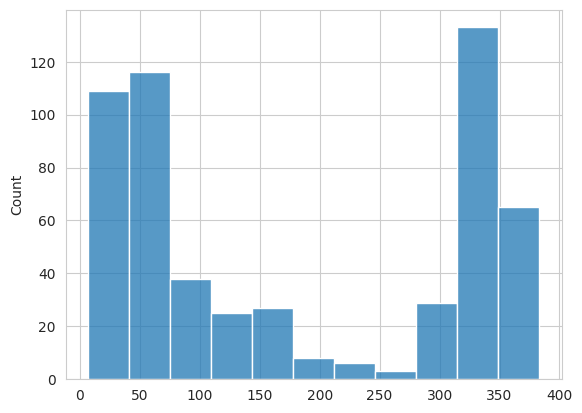

In [59]:
sns.histplot(np.array(load_chunks))

In [60]:
len(all_chunks)

559

In [74]:
tokenized_corpus = [word_tokenize(doc.page_content.lower()) for doc in all_chunks]
bm25 = BM25Okapi(tokenized_corpus)
query = "The role of agriculture in shaping military strategies of ancient societies according to Hanson"
tokenized_query = word_tokenize(query.lower())
doc_scores = bm25.get_scores(tokenized_query)
best_doc_index = doc_scores.argmax()
print("Лучший документ:", all_chunks[best_doc_index])

Лучший документ: page_content='passage: page_9 < previous page page_9 next page > Page 9 The primacy of land both as an object of attack and as grounds for infantry defense holds true for a good many Greek states in the classical period and serves well as a model against which exceptions can be illustrated. Some backward societies in mountainous areas in Crete and Aetolia, where the agrarian polis was less developed, for example, made exclusive use of light-armed troops in attacking the enemy in border passes. Effective cavalry overshadowed infantry in Thessaly and anywhere else where wide plains made their use attractive and where agriculture was practiced under different cultural and legal protocols, which emphasized aristocracy and monarchy rather than broad-based oligarchy and timocracy. We hear, too, of occasional ingenious sieges at Plataia and later at Mantineia, as the Peloponnesian War and subsequent fighting illustrated the sometime artificial and static nature of war framed 

In [75]:
import shutil
persist_directory = "rag_vector_db"
shutil.rmtree(persist_directory)

In [76]:
vector_db = Chroma.from_documents(
    all_chunks,
    embedding_model,
    persist_directory="rag_vector_db"
)

In [77]:
len(vector_db)

559

### Простая проверка всё ли ок

In [78]:
formatted_query = "query: " + "Война и сельское хозяйство?"  # Обязательно для E5!
relevant_docs = vector_db.similarity_search(formatted_query, k=10)

In [79]:
relevant_docs

[Document(metadata={'title': 'cover', 'moddate': '2009-02-10T21:58:13+00:00', 'page_label': '2', 'total_pages': 359, 'start_index': 0, 'producer': 'Acrobat Web Capture 8.0', 'creationdate': '2009-02-10T20:44:22+00:00', 'source': './data/referat_3/Victor Davis Hanson - Warfare and Agriculture in Classical Greece, Revised edition (Biblioteca Di Studi Antichi, 40) (1998).pdf', 'page': 1, 'creator': 'Adobe Acrobat 8.1 Combine Files'}, page_content='passage: Page i Warfare and Agriculture in Classical Greece'),
 Document(metadata={'creationdate': '2009-02-10T20:44:22+00:00', 'creator': 'Adobe Acrobat 8.1 Combine Files', 'total_pages': 359, 'page_label': '215', 'source': './data/referat_3/Victor Davis Hanson - Warfare and Agriculture in Classical Greece, Revised edition (Biblioteca Di Studi Antichi, 40) (1998).pdf', 'start_index': 0, 'moddate': '2009-02-10T21:58:13+00:00', 'producer': 'Acrobat Web Capture 8.0', 'title': 'cover', 'page': 214}, page_content="passage: Page 201 UPDATED COMMENTAR

In [95]:
ref_topic = "Война и сельское хозяйство в работах Виктора Хэнсена"
f'{ref_topic}'

'Война и сельское хозяйство в работах Виктора Хэнсена'

In [96]:
prompt_for_questions = f"Привет! Мне нужно написать реферат на тему '{ref_topic}. Сгенерируй мне вопросы(11-12), на которые мне необходимо ответить, чтобы раскрыть тему и написать реферат на 5-6 страниц 14-ым шрифтом. Впоросы пиши просто как запрос, а не как вопрос. Предоставь ответ в виде словаря в питоне, где ключом является вопрос на русском, а значением этот же вопрос на английском."
print(prompt_for_questions)

Привет! Мне нужно написать реферат на тему 'Война и сельское хозяйство в работах Виктора Хэнсена. Сгенерируй мне вопросы(11-12), на которые мне необходимо ответить, чтобы раскрыть тему и написать реферат на 5-6 страниц 14-ым шрифтом. Впоросы пиши просто как запрос, а не как вопрос. Предоставь ответ в виде словаря в питоне, где ключом является вопрос на русском, а значением этот же вопрос на английском.


In [82]:
referat_3_1 = {  
    "Анализ ключевых работ Виктора Хэнсена, посвященных взаимосвязи войны и сельского хозяйства":  
    "Analysis of Victor Hanson's key works exploring the relationship between war and agriculture",  

    "Роль сельского хозяйства в формировании военных стратегий древних обществ по Хэнсену":  
    "The role of agriculture in shaping military strategies of ancient societies according to Hanson",  

    "Влияние войны на развитие аграрных технологий и землепользования в исторической перспективе":  
    "The impact of war on the development of agrarian technologies and land use in historical perspective",  

    "Концепция 'гражданского солдата-фермера' в интерпретации Хэнсена":  
    "The concept of the 'citizen-soldier-farmer' in Hanson's interpretation",  

    "Примеры из античной истории, иллюстрирующие симбиоз военной и сельскохозяйственной систем":  
    "Examples from ancient history illustrating the symbiosis of military and agricultural systems",  

    "Критика теорий Хэнсена в современной историографии":  
    "Criticism of Hanson's theories in modern historiography",  

    "Сравнительный анализ аграрных основ войн в древнегреческой и римской цивилизациях":  
    "Comparative analysis of agrarian foundations of wars in ancient Greek and Roman civilizations",  

    "Эволюция взаимоотношений войны и сельского хозяйства в работах Хэнсена для разных исторических эпох":  
    "Evolution of the relationship between war and agriculture in Hanson's works across historical eras",  

    "Современное значение теорий Хэнсена для понимания глобальных продовольственных кризисов и конфликтов":  
    "Modern relevance of Hanson's theories for understanding global food crises and conflicts"  
}  

In [97]:
referat_3_2 = {
    "Ключевые работы Виктора Хэнсена, исследующие взаимосвязь войны и сельского хозяйства": 
    "Victor Hanson's key works exploring the relationship between war and agriculture",
    
    "Роль сельского хозяйства в формировании военных стратегий древних обществ по Хэнсену": 
    "The role of agriculture in shaping military strategies of ancient societies in Hanson's view",
    
    "Концепция 'гражданин-солдат-фермер' в интерпретации Хэнсена": 
    "The concept of the 'citizen-soldier-farmer' in Hanson's interpretation",
    
    "Примеры из античной истории, иллюстрирующие симбиоз военных и аграрных систем": 
    "Examples from ancient history illustrating the symbiosis of military and agricultural systems",
    
    "Влияние войн на развитие аграрных технологий и использование земель": 
    "The impact of wars on the development of agrarian technologies and land use",
    
    "Критика теорий Хэнсена в современной историографии": 
    "Criticism of Hanson's theories in modern historiography",
    
    "Аграрные основы войн в древнегреческой и римской цивилизациях: сравнительный анализ": 
    "Agrarian foundations of wars in Greek and Roman civilizations: a comparative analysis",
    
    "Эволюция взаимосвязи войны и сельского хозяйства в работах Хэнсена": 
    "The evolution of war-agriculture relationship in Hanson's works",
    
    "Современная актуальность теорий Хэнсена для понимания глобальных продовольственных кризисов": 
    "Modern relevance of Hanson's theories for understanding global food crises",
    
    "Методология Хэнсена: источники и исследовательские подходы": 
    "Hanson's methodology: sources and research approaches",
    
    "Социально-экономические последствия войн для сельских общин в трактовке Хэнсена": 
    "Socio-economic consequences of wars for rural communities in Hanson's interpretation",
    
    "Вклад Хэнсена в изучение античной истории и военной стратегии": 
    "Hanson's contribution to the study of ancient history and military strategy"
}

In [98]:
start_prompt = f'Привет! Мне нужен реферат на тему "{ref_topic}". Далее будет список вопросов и ответов на них. Вопросы будут на русском и релевантные ответы на них.\nОтветы содержат ещё и мета информацию, "source" - это источник ответа, "page_label" - номер странцы.\nМне нужно, чтобы из данной информации ты собрала реферат на 5-6 страниц(14 шрифт в ворде)  на русском.\n Пиши обычный реферат, не сухую выжимку, можешь немного лить воды. С введением, с переходами и указанием ссылок, не опускай мелкие факты.'

In [99]:
start_prompt

'Привет! Мне нужен реферат на тему "Война и сельское хозяйство в работах Виктора Хэнсена". Далее будет список вопросов и ответов на них. Вопросы будут на русском и релевантные ответы на них.\nОтветы содержат ещё и мета информацию, "source" - это источник ответа, "page_label" - номер странцы.\nМне нужно, чтобы из данной информации ты собрала реферат на 5-6 страниц(14 шрифт в ворде)  на русском.\n ПИШИ ЧЕЛОВЕЧЕСКИЙ РЕФЕРАТ, не сухую выжимку, можешь немного лить воды. С введением, с переходами и указанием ссылок, не опускай мелкие факты.'

In [100]:
def generate_prompt(questions, vector_db, start_prompt, lang_flag = ["rus", "en"], bm25 = None, topK=2):
    reformat_quest  = lambda query: f"query: {query}"
    body_prompt = []
    for rus_question, eng_question in questions.items():
        if  "en" in lang_flag:
            sub_body_prompt = f"<Question>: {eng_question},\n <answers>: "
        else:
            sub_body_prompt = f"<Question>: {rus_question},\n <answers>: "
        final_request_prompt_rus = reformat_quest(rus_question)
        final_request_prompt_en = reformat_quest(eng_question)
        ans_cleaned = []
        def retrive_by_lang(final_request_prompt):
            for relevant_order, ans in enumerate(vector_db.similarity_search(final_request_prompt, k=topK)):
                ans_cleaned.append(f"<{relevant_order}>: {ans.page_content}.\n <source>: {ans.metadata['source']}\n<page_label>: {ans.metadata['page_label']}\n-------------------------")
            if  bm25!= None:
                tokenized_query = word_tokenize(final_request_prompt.lower())
                doc_scores = bm25.get_scores(tokenized_query)
                best_doc_index = doc_scores.argmax()
                ans = all_chunks[best_doc_index]
                ans_cleaned.append(f"<{topK}>: {ans.page_content}.\n <source>: {ans.metadata['source']}\n<page_label>: {ans.metadata['page_label']}\n-------------------------")
        if  "rus" in lang_flag:
            retrive_by_lang(final_request_prompt_rus)
        if "en" in lang_flag:
             retrive_by_lang(final_request_prompt_en)
        res = sub_body_prompt + '\n' + '\n'.join(ans_cleaned)
        body_prompt.append(res)
    final_prompt = start_prompt + '\n\n' + '\n'.join(body_prompt)
    return final_prompt

In [101]:
print(generate_prompt(referat_3_2, vector_db, start_prompt,lang_flag = ["en"], bm25 = bm25, topK=2))

Привет! Мне нужен реферат на тему "Война и сельское хозяйство в работах Виктора Хэнсена". Далее будет список вопросов и ответов на них. Вопросы будут на русском и релевантные ответы на них.
Ответы содержат ещё и мета информацию, "source" - это источник ответа, "page_label" - номер странцы.
Мне нужно, чтобы из данной информации ты собрала реферат на 5-6 страниц(14 шрифт в ворде)  на русском.
 ПИШИ ЧЕЛОВЕЧЕСКИЙ РЕФЕРАТ, не сухую выжимку, можешь немного лить воды. С введением, с переходами и указанием ссылок, не опускай мелкие факты.

<Question>: Victor Hanson's key works exploring the relationship between war and agriculture,
 <answers>: 
<0>: passage: Page iii Warfare and Agriculture in Classical Greece Victor Davis Hanson UNIVERSITY OF CALIFORNIA PRESS Berkeley Los Angeles London.
 <source>: ./data/referat_3/Victor Davis Hanson - Warfare and Agriculture in Classical Greece, Revised edition (Biblioteca Di Studi Antichi, 40) (1998).pdf
<page_label>: 4
-------------------------
<1>: passa